In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
sns.set_style('white')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from LB_D2Q9.dimensionless import opencl_dim as lb_cl
from LB_D2Q9.dimensionless import cython_dim as lb_cython
from LB_D2Q9.dimensionless import python_dim as lb_python

We want to profile our code now. Let's compare python, cython, and OpenCL.

In [7]:
from IPython import display

# Obtaining MLUPS: Million Lattice Updates per Second

We give each simulation the same input parameters for simplicity.

In [8]:
N = 125 # Number of grid points covering characteristic length scale

D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -10 # Pa/m

pipe_length = 3*D # meter

# initialize cylinder
cylinder_center = [pipe_length/4, D/2]
cylinder_radius = D/10

sim_cl = lb_cl.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                             N=N, time_prefactor=1.,
                             cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                             two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
2d global: (3776, 1280)
2d local: (32, 32)
3d global: (3776, 1280, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices
inlet rho: 1.00368738304
outlet rho: 1.0


In [9]:
sim_cython = lb_cython.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=N, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
inlet rho: 1.00368738304
outlet rho: 1.0


In [10]:
sim_python = lb_python.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=N, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
inlet rho: 1.00368738304
outlet rho: 1.0


In [11]:
total_lattice_size = sim_cl.nx*sim_cl.ny
print 'Lattice size is ' , '%.3e' % total_lattice_size

Lattice size is  4.693e+06


In [12]:
import time

## OpenCL

In [13]:
num_steps = 1000

start_time = time.time()
sim_cl.run(num_steps)
end_time = time.time()

time_elapsed = end_time - start_time
print 'Iterations completed:' , num_steps
print 'Time elapsed (s): ', time_elapsed 
opencl_MLUPS = (num_steps*(total_lattice_size/10.**6.))/time_elapsed
print 'MLUPS:' , opencl_MLUPS

Iterations completed: 1000
Time elapsed (s):  14.4930200577
MLUPS: 323.776616697


Ok, so we get 325 million lattice updtates per second! That is not bad! We can speed this up too by further optimizing our kernels.

In [14]:
%%prun 

sim_cl.run(num_steps)

```
119004 function calls in 14.528 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    4.873    0.005    4.927    0.005 opencl_dim.py:266(update_feq)
     1000    3.846    0.004    3.936    0.004 opencl_dim.py:229(move)
     1000    2.807    0.003    2.854    0.003 opencl_dim.py:275(collide_particles)
     1000    1.207    0.001    1.255    0.001 opencl_dim.py:260(update_hydro)
     1000    1.069    0.001    1.116    0.001 opencl_dim.py:223(move_bcs)
     1000    0.178    0.000    1.339    0.001 opencl_dim.py:392(move_bcs)
     8000    0.175    0.000    0.260    0.000 __init__.py:499(kernel_call)
     1000    0.167    0.000    1.467    0.001 opencl_dim.py:386(update_hydro)
     8000    0.059    0.000    0.071    0.000 __init__.py:530(kernel_set_args)
     8000    0.047    0.000    0.070    0.000 __init__.py:492(kernel_init)
     8000    0.033    0.000    0.116    0.000 __init__.py:164(__getattr__)
    16000    0.016    0.000    0.016    0.000 __init__.py:317(result)
    24000    0.014    0.000    0.014    0.000 {method 'pop' of 'dict' objects}
    16000    0.013    0.000    0.013    0.000 {getattr}
     8000    0.008    0.000    0.008    0.000 {isinstance}
     8000    0.006    0.000    0.006    0.000 __init__.py:133(_get_prg)
        1    0.006    0.006   14.528   14.528 opencl_dim.py:280(run)
     8000    0.005    0.000    0.005    0.000 {len}
        1    0.000    0.000    0.000    0.000 {range}
        1    0.000    0.000   14.528   14.528 <string>:3(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

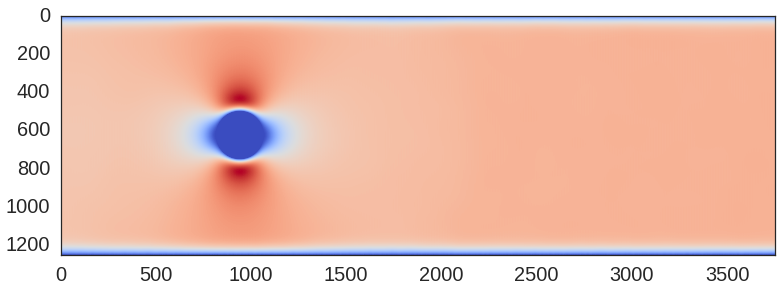

In [15]:
fields_cl = sim_cl.get_nondim_fields()
plt.imshow(fields_cl['u'].T, cmap=cm.coolwarm)

## Cython

In [16]:
num_steps = 20

start_time = time.time()
sim_cython.run(num_steps)
end_time = time.time()

time_elapsed = end_time - start_time
print 'Iterations completed:' , num_steps
print 'Time elapsed (s): ', time_elapsed 
cython_MLUPS = (num_steps*(total_lattice_size/10.**6.))/time_elapsed
print 'MLUPS:' , cython_MLUPS

Iterations completed: 20
Time elapsed (s):  15.9564828873
MLUPS: 5.88162320375


In [133]:
num_steps = 20

In [134]:
%%prun

sim_cython.run(num_steps)

```
623 function calls in 15.790 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    9.620    0.481    9.620    0.481 cython_dim.pyx:132(update_feq)
       20    2.304    0.115    2.304    0.115 cython_dim.pyx:292(collide_particles)
       20    2.179    0.109    2.179    0.109 cython_dim.pyx:255(move)
       20    1.034    0.052    1.513    0.076 cython_dim.pyx:160(update_hydro)
       20    0.479    0.024    0.479    0.024 {method 'reduce' of 'numpy.ufunc' objects}
       20    0.160    0.008    1.673    0.084 cython_dim.pyx:377(update_hydro)
       20    0.006    0.000    0.013    0.001 cython_dim.pyx:382(move_bcs)
       20    0.006    0.000    0.007    0.000 cython_dim.pyx:191(move_bcs)
        1    0.000    0.000   15.790   15.790 cython_dim.pyx:299(run)
      100    0.000    0.000    0.000    0.000 stringsource:319(__cinit__)
       20    0.000    0.000    0.480    0.024 fromnumeric.py:1733(sum)
      100    0.000    0.000    0.000    0.000 stringsource:615(memoryview_cwrapper)
       20    0.000    0.000    0.000    0.000 {isinstance}
      100    0.000    0.000    0.000    0.000 stringsource:341(__dealloc__)
       20    0.000    0.000    0.479    0.024 _methods.py:31(_sum)
      100    0.000    0.000    0.000    0.000 stringsource:621(memoryview_check)
        1    0.000    0.000   15.790   15.790 <string>:3(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

The plot will be significantly less developed, i.e. the pipe just turning on, as we completed far less iterations. There will likely be large fluctuations.

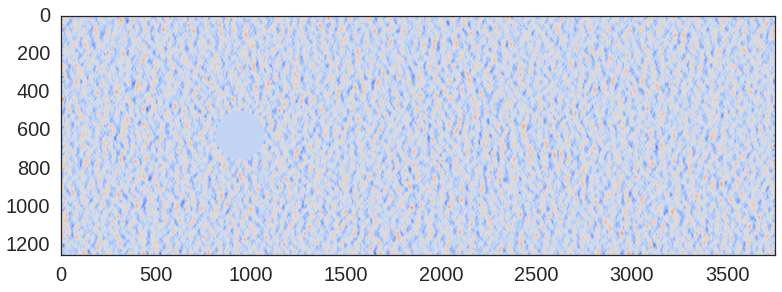

In [17]:
plt.imshow(sim_cython.u.T, cmap=cm.coolwarm)
plt.grid(False)

## Python

In [18]:
num_steps = 3

start_time = time.time()
sim_python.run(num_steps)
end_time = time.time()

time_elapsed = end_time - start_time
print 'Iterations completed:' , num_steps
print 'Time elapsed (s): ', time_elapsed 
python_MLUPS = (num_steps*(total_lattice_size/10.**6.))/time_elapsed
print 'MLUPS:' , (num_steps*(total_lattice_size/10.**6.))/time_elapsed

Iterations completed: 3
Time elapsed (s):  28.0568161011
MLUPS: 0.50174984037


In [136]:
%%prun

sim_python.run(num_steps)

```
15058 function calls in 28.306 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3   25.691    8.564   25.879    8.626 python_dim.py:251(move)
        3    1.441    0.480    1.441    0.480 python_dim.py:130(update_feq)
        3    0.363    0.121    0.384    0.128 python_dim.py:375(move_bcs)
        3    0.346    0.115    0.346    0.115 python_dim.py:285(collide_particles)
    15022    0.189    0.000    0.189    0.000 {range}
        3    0.155    0.052    0.227    0.076 python_dim.py:158(update_hydro)
        3    0.072    0.024    0.072    0.024 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.025    0.008    0.252    0.084 python_dim.py:370(update_hydro)
        3    0.019    0.006    0.019    0.006 python_dim.py:189(move_bcs)
        1    0.004    0.004   28.306   28.306 python_dim.py:292(run)
        3    0.000    0.000    0.072    0.024 fromnumeric.py:1733(sum)
        3    0.000    0.000    0.072    0.024 _methods.py:31(_sum)
        1    0.000    0.000   28.306   28.306 <string>:3(<module>)
        3    0.000    0.000    0.000    0.000 {isinstance}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

The flow field will be even less developed here. We could only run about 3 iterations in 30 seconds.

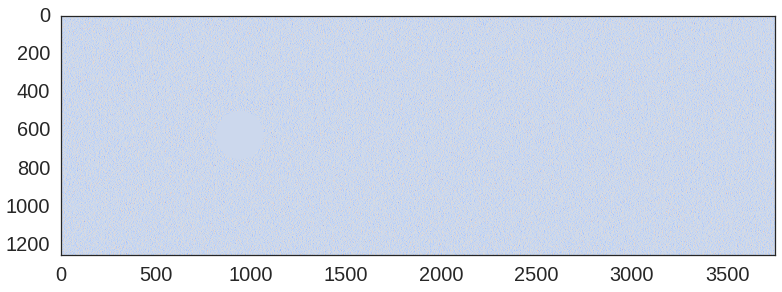

In [19]:
plt.imshow(sim_python.u.T, cmap=cm.coolwarm)
plt.grid(False)

# Plotting Implementation Speedup

It is clear that we acheived some incredible speedups. Let's make a plot illustrating this.

In [83]:
sns.set_style('ticks')
import matplotlib
matplotlib.rc('text', usetex=True)

In [84]:
import pandas as pd

In [85]:
data_list = []
columns = ['Implementation', 'MLUPS']
data_list.append(['Python', python_MLUPS])
data_list.append(['Cython', cython_MLUPS])
data_list.append(['OpenCL', opencl_MLUPS])

speedup_df = pd.DataFrame(data=data_list, columns=columns)

In [86]:
speedup_df

,Implementation,MLUPS
0,Python,0.499527
1,Cython,5.929261
2,OpenCL,324.892949


In [87]:
speedup_df['speedup'] = speedup_df['MLUPS']/np.min(speedup_df['MLUPS'])

In [138]:
speedup_df

,Implementation,MLUPS,speedup
0,Python,0.499527,1.000000
1,Cython,5.929261,11.869743
2,OpenCL,324.892949,650.400743


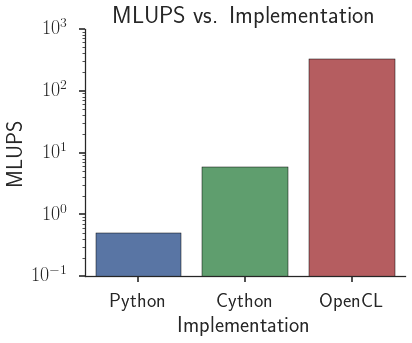

In [126]:
sns.factorplot(data=speedup_df, x='Implementation', y='MLUPS', kind='bar')
plt.gca().set_yscale('log')
plt.title('MLUPS vs. Implementation')
plt.gcf().set_size_inches(6.5, 5)

plt.savefig('mlups_vs_implementation.png', dpi=200, bbox_inches='tight')
plt.savefig('mlups_vs_implementation.eps', dpi=200, format='eps', bbox_inches='tight')

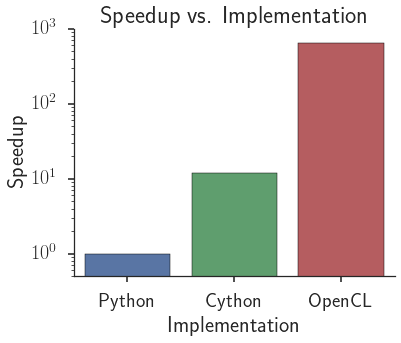

In [127]:
sns.factorplot(data=speedup_df, x='Implementation', y='speedup', kind='bar')
plt.ylabel('Speedup')
plt.gca().set_yscale('log')
plt.ylim(.5, 10.**3.)
plt.title('Speedup vs. Implementation')

plt.gcf().set_size_inches(6.5, 5)

plt.savefig('speedup_vs_implementation.png', dpi=200, bbox_inches='tight')
plt.savefig('speedup_vs_implementation.eps', dpi=200, format='eps', bbox_inches='tight')